## COMP5625M Assessment 1 - Image Classification [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected images from section 6 "Failure/success analysis" (outputs from gradcam, for example you can put these images into failure and succcess folders).

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.



Your student username (for example, ```sc15jb```):

--> double click to respond

Your full name:

--> double click to respond

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
# Imports
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

import os
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torchvision.utils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from natsort import natsorted

import time

C:\Users\Laptop\anaconda3\envs\deepL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check version
print(torch.__version__)
# check if gpu/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.13.1
Using device: cuda


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** (12 marks)

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (4 marks)

**2. Model training** (20 marks)
*   **2.1** Train on TinyImageNet30 dataset (7 marks)
*   **2.2** Generate confusion matrices and ROC curves (4 marks)
*   **2.3** Strategies for tackling overfitting (9 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** (20 marks)
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) (8 marks)
*   **3.2** Fine-tune model with frozen base convolution layers (8 marks)
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? (4 marks) 

**4. Model testing** (18 marks)
*   **4.1**   Test your final model in (2) on test set - code to do this (10 marks)
*   **4.2**   Upload your result to Kaggle  (8 marks)

**5. Model comparison** (14 marks)
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (6 marks)
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks)

**6. Interpretation of results** (16 marks)
*   **6.1** Use grad-CAM on your model and on AlexNet (6 marks)
*   **6.2** Visualise and compare the results from your model and from AlexNet (4 marks)
*   **6.3** Comment on (6 marks):
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations [12 marks]


### 1.1 Dataset class [4 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [3]:
# path to training data set
ROOT = "C:/Users/Laptop/Desktop/cw/"
DATA_DIR = ROOT + "train_set/train_set/"
CLASS_TXT_LABELS = ['baboon', 'banana', 'bee', 'bison', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 
                    'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod',
                   'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda',
                   'refrigerator', 'sombrero', 'umbrella']

# Dataset class for TinyImage30
class LoadTinyImage30TrainSet(ImageFolder):
    def __init__(
        self, 
        root: str = DATA_DIR,
        transform = transforms.ToTensor()
    ):
        super(LoadTinyImage30TrainSet, self).__init__(root=root,transform=transform)
        
    def __len__(self):
        return len(self.imgs)

# utility method to plot tensor images
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa

%matplotlib inline

Printing an example of image, size and label...
torch.Size([3, 64, 64])
1
Expected an image of a banana and associated label 1.



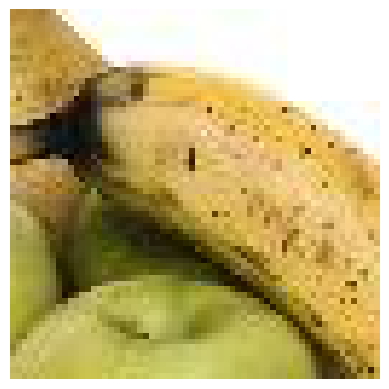

In [4]:
# load the TinyImage30 dataset
train_set = LoadTinyImage30TrainSet()
validation_set = LoadTinyImage30TrainSet()

# inspect some of the data as a sanity check
data, label = train_set[450]
print("Printing an example of image, size and label...")
print(data.size())
print(label)
print("Expected an image of a banana and associated label 1.")
print()

# plot an image as a sanity check
timshow(data)

# handle partitioning of train & validation sets 
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train)) # 20 % used for validation

np.random.seed(0) # with shuffle seed 0 for reproducability
np.random.shuffle(indices)

train_idx, validation_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx) 

number of training set images: 10816
number of validation set images: 2720


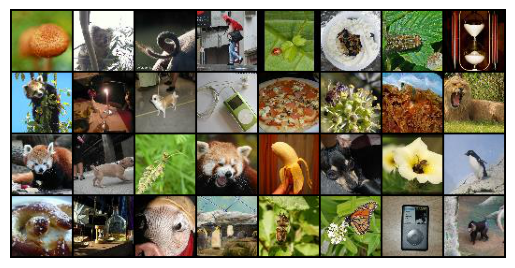

In [5]:
# adjust appropriately depending on GPU resources available / size of problem to speed up training
BATCH_SIZE = 32
# adjust appropriately depending on CPU architecture to speed-up loading
NUM_WORKERS = 0

# from created partitions LOAD:

# the training set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

# validation set
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE,  
                          num_workers=NUM_WORKERS, sampler=validation_sampler)

# by confirming size of partitions after loading
print("number of training set images: " + str(len(train_loader)*BATCH_SIZE))
print("number of validation set images: " + str(len(validation_loader)*BATCH_SIZE))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images and labels
_ = timshow(torchvision.utils.make_grid(images))

### 1.2 Define a MLP model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [7]:
class MLPClassifier(nn.Module):
    
    def __init__(self, num_classes=30): # TinyImage30 data contains 30 class labels
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 120) # the input is a 64x64 image with 3 color channels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,30)
        
    def forward(self, x):
        out = torch.flatten(x, 1) # flatten all dimensions except batch
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
mlp_net = MLPClassifier()
mlp_loss_fn = nn.CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp_net.parameters(), lr=0.01, momentum=0.9)
print(mlp_net)

MLPClassifier(
  (fc1): Linear(in_features=12288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


### 1.3 Define a CNN model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [8]:
class CNNClassifier(nn.Module):
    
    def __init__(self, num_classes=30): # TinyImage30 data contains 30 class labels
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=40,kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=40,out_channels=80,kernel_size=3)
        self.fc1 = nn.Linear(15680, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
cnn_net = CNNClassifier()
cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = optim.SGD(cnn_net.parameters(), lr=0.01, momentum=0.9)
print(cnn_net) 

CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)


## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [9]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [10]:
def train_model(nepochs: int, model, loss_fn, optimizer, root_path: str, file_name: str):
    if torch.cuda.is_available(): # load the network in GPU if available
        model = model.cuda()
        
    max_validation_acc = np.NINF
    statsrec = np.zeros((4,nepochs)) # record stats for testing & validation

    for epoch in range(nepochs):  # loop over the dataset multiple times
        train_loss = 0.0   # accumulated loss
        train_acc = 0.0    # accumulated accuracy
        n = 0 # batch counter for averaging accumulated values

        for data, labels in train_loader:
            if torch.cuda.is_available(): # load the data in GPU if available
                data, labels = data.cuda(), labels.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # accumulate loss
            train_loss += loss.item()
            # accumulate topk accuracy
            train_acc += torch.tensor(topk_accuracy(outputs, labels), device = 'cpu').item()
            n += 1
     
        # collect together statistics for this epoch (take the mean across all batches)
        train_loss = train_loss/n
        train_acc = train_acc/n

        print(f"Epoch {epoch} \t\t training loss: {train_loss: .3f}")
        print(f"Epoch {epoch} \t\t training topk accuracy: {train_acc: .3f}")

        # accumulate loss & accuracy for validation
        validation_loss = 0.0
        validation_acc = 0.0
        n = 0
        # evaluate, e.g. do not compute gradients for validation
        model.eval()
        for data, labels in validation_loader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            output = model(data)
            loss = loss_fn(output,labels)
            validation_loss += loss.item()
            validation_acc += torch.tensor(topk_accuracy(output, labels), device = 'cpu').item()
            n += 1

        # average the accumulated values
        validation_loss = validation_loss / n
        validation_acc = validation_acc / n
        # record the stats for this epoch
        statsrec[:,epoch] = (train_loss, train_acc, validation_loss, validation_acc)
        
        # update new maximum
        if validation_acc > max_validation_acc:  
            max_validation_acc = validation_acc
            # save network parameters, losses and accuracy to 
            # specified path when validation acc is at maximum
            optimal_path = root_path + "results/optimal_" + file_name + ".pt"
            torch.save({"state_dict": model.state_dict(), "stats": statsrec}, optimal_path)
            print(f"Epoch {epoch} \t\t new validation accuracy maximum {validation_acc: .3f}")
        
        # save the sub-optimal network as well to plot graph for Section (2.1)
        results_path = root_path + "results/" + file_name + ".pt"
        torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

In [151]:
# train the MLP model
train_model(100, mlp_net, mlp_loss_fn, mlp_optimizer, ROOT, "mlpclassifier")

Epoch 0 		 training loss:  3.215
Epoch 0 		 training topk accuracy:  9.209
Epoch 0 		 new validation accuracy maximum  10.846
Epoch 1 		 training loss:  3.012
Epoch 1 		 training topk accuracy:  13.425
Epoch 1 		 new validation accuracy maximum  14.547
Epoch 2 		 training loss:  2.922
Epoch 2 		 training topk accuracy:  15.616
Epoch 2 		 new validation accuracy maximum  15.490
Epoch 3 		 training loss:  2.857
Epoch 3 		 training topk accuracy:  18.010
Epoch 3 		 new validation accuracy maximum  17.525
Epoch 4 		 training loss:  2.814
Epoch 4 		 training topk accuracy:  19.000
Epoch 5 		 training loss:  2.797
Epoch 5 		 training topk accuracy:  19.212
Epoch 6 		 training loss:  2.774
Epoch 6 		 training topk accuracy:  19.351
Epoch 7 		 training loss:  2.728
Epoch 7 		 training topk accuracy:  21.228
Epoch 7 		 new validation accuracy maximum  19.510
Epoch 8 		 training loss:  2.711
Epoch 8 		 training topk accuracy:  21.089
Epoch 9 		 training loss:  2.700
Epoch 9 		 training topk accu

In [11]:
# utility function to graph stats for models
def plot_model_train_stats(results_path, 
                           fig_name: str="roc.svg", 
                           title: str="Training and validation loss & topk accuracy",
                           nepochs=None):
    data = torch.load(results_path)
    statsrec = data["stats"]
    if nepochs != None:
        statsrec = statsrec[:,:nepochs]
        
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'validation loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig(fig_name)
    plt.show()

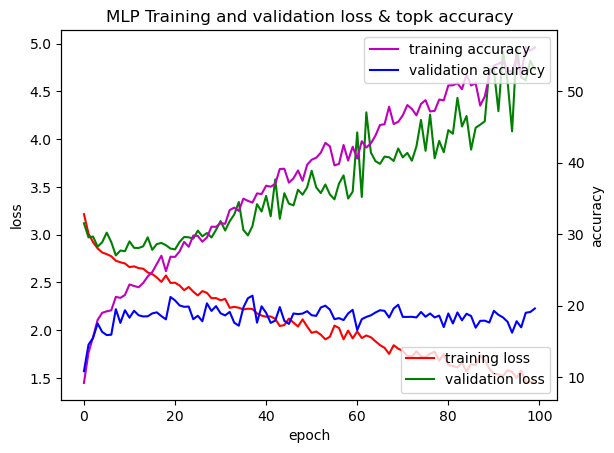

In [152]:
# graph for the MLP model
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/mlpclassifier.pt",
                       "roc_mlp.svg", 
                       "MLP Training and validation loss & topk accuracy")

In [13]:
# train the CNN model
train_model(100, cnn_net, cnn_loss_fn, cnn_optimizer, ROOT, "cnnclassifier")

Epoch 0 		 training loss:  3.327
Epoch 0 		 training topk accuracy:  6.481
Epoch 0 		 new validation accuracy maximum  9.289
Epoch 1 		 training loss:  2.893
Epoch 1 		 training topk accuracy:  16.309
Epoch 1 		 new validation accuracy maximum  21.801
Epoch 2 		 training loss:  2.599
Epoch 2 		 training topk accuracy:  23.752
Epoch 2 		 new validation accuracy maximum  25.527
Epoch 3 		 training loss:  2.440
Epoch 3 		 training topk accuracy:  28.301
Epoch 3 		 new validation accuracy maximum  28.627
Epoch 4 		 training loss:  2.302
Epoch 4 		 training topk accuracy:  32.535
Epoch 4 		 new validation accuracy maximum  30.797
Epoch 5 		 training loss:  2.134
Epoch 5 		 training topk accuracy:  36.779
Epoch 5 		 new validation accuracy maximum  33.382
Epoch 6 		 training loss:  1.921
Epoch 6 		 training topk accuracy:  42.807
Epoch 6 		 new validation accuracy maximum  36.324
Epoch 7 		 training loss:  1.690
Epoch 7 		 training topk accuracy:  49.131
Epoch 7 		 new validation accuracy ma

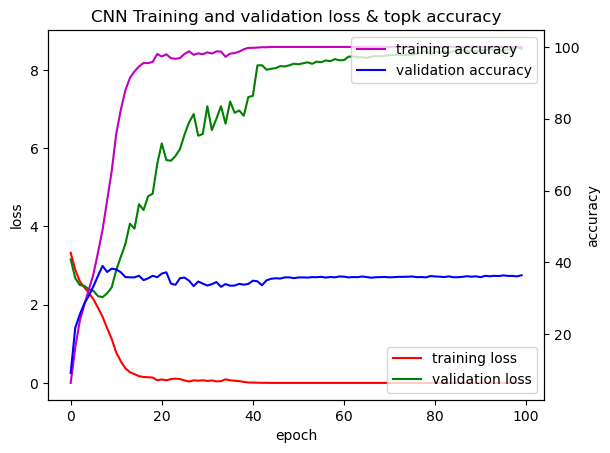

In [40]:
# graph for the CNN model
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/cnnclassifier.pt", 
                       "roc_cnn.svg",
                       "CNN Training and validation loss & topk accuracy")

In [153]:
mlp_parameters = filter(lambda p: p.requires_grad, mlp_net.parameters())
n_params = sum([np.prod(p.size()) for p in mlp_parameters])
print(f"MLP model has a total of {n_params} trainable parameters")

cnn_parameters = filter(lambda p: p.requires_grad, cnn_net.parameters())
n_params = sum([np.prod(p.size()) for p in cnn_parameters])
print(f"CNN model has a total of {n_params} trainable parameters")

MLP model has a total of 1487394 trainable parameters
CNN model has a total of 1924434 trainable parameters


> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

Both models are fully-connected and take as input a 64x64 image with 3 color channels and output the predicted class of the image (out of 30). However, they differ in their structure and performance. 

The MLP model consists of 2 linear hidden layers which with 120 and 84 neuron nodes respectively. The activation function used for the neurons is rectified linear unit (relu). The MLP model has a total of 1487394 trainable parameters. 

In contrast, the CNN model has 2 convolution layers with 40 kernels in the first convolution layer and 80 in the second. Both kernels are of size 3x3, furthermore the output from the first convolution layer is 2x2 max pooled. This is followed by 2 relu activated linear hidden layers with 120 and 84 neurons respectively. The CNN model has a total of 1924434 trainable parameters.
The CNN model is twice as accurate in classifying images compared to the MLP. This is because convolutions can extract local (spatial) features as they compute the weighted sum of values in its receptive window into a single value.  This also means that individual convolution output will not be affected by changes of pixel values outside of its receptive window, in contrast to MLP. Furthermore, combining layers of these convolutions allows the model to extract larger and more complex features in images – for instance the head, tail of an animal etc.

### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [12]:
def generate_cnfm(net, loader, n, results_path):
    d = torch.load(results_path)
    # load the parameter state
    net.load_state_dict(d["state_dict"])

    # initialise array of size=n (number of classes)
    classes = np.arange(0, n)
    
    # initialise confusion matrix
    nclasses = classes.shape[0]
    cnfm = np.zeros((nclasses,nclasses),dtype=float)

    # work without gradient computation since we are testing (i.e. no optimisation)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)

            # find the class with the highest output.
            # note that the outputs are confidence values since we didn't need to apply softmax in our network
            # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
            _, predicted = torch.max(outputs, 1)    


            # accumulate into confusion matrix
            for i in range(labels.size(0)):
                cnfm[labels[i].item(),predicted[i].item()] += 1

    return cnfm

# converts the confusion matrix from raw output values to fraction from total
def conv_cnfm_percent(cnfm):
    nentries = cnfm.sum((0,1)) # the total number of entries used for training
    # the cnfm output contains count of entries, thus compute the percent from total
    percent_from_total = (1 / nentries) * 100
    return(cnfm * percent_from_total)

def display_cnfm(cnfm, title: str="Confusion matrix on model", gray_map=True):
    print(title)
    print("Each entry indicates percent from total.")
    print()
    np.set_printoptions(precision=2) # float precision to display when printing
    print(conv_cnfm_percent(cnfm))

    if gray_map:
        # show confusion matrix as a grey-level image
        print()
        print("Grey scale mapping of the confusion matrix.")
        gray_map = plt.imshow(cnfm, cmap='gray')
         
# return the indeces=labels of the top 5 most accurate classes from cnfm
def get_top5(cnfm):
    correct = np.diag(cnfm) # the diagonal represents correct predictions
    return correct.argsort()[::-1][:5] # sort in descending format and take top 5 (most accurate classes)

# computes prediction probabilities of each class 
def calc_y_probs(cnfm, nclasses):
    y_probs = np.zeros((nclasses),dtype=float)
    frac_cnfm = (conv_cnfm_percent(cnfm) / 100) # converts percentile cnfm to fraction of total
    for i in range(nclasses):
        # the prediction probability for each class is the sum of fractions in that row,
        #                             Actual class: (nclasses)
        # Predicted class (nclasses): x x x x x x x x x x x x (<--sum here)
        #                             x x x x x x x x x x x x
        y_probs[i] = frac_cnfm[i][:].sum() 
    return y_probs
     
# displays ROC for top 5 most accurate classes
def display_roc(cnfm, nclasses):
    top5_idx = get_top5(cnfm)
    
    y = np.arange(0, nclasses)
    y_probs = calc_y_probs(cnfm, nclasses)
    
    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--', label="ROC curve for chance level (AUC = 0.5)")
    
    j = 1
    for i in top5_idx:

        # fpr, tpr, thresholds = metrics.roc_curve(y, y_probs, pos_label=i)
        fpr, tpr, thresholds = roc_curve(y, y_probs , pos_label=i)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label=f"Top {j} class: {CLASS_TXT_LABELS[i]} (AUC={roc_auc: .3f})")
        j += 1
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.35),
        ncol=3, 
    )
    plt.show()

In [55]:
net = CNNClassifier()
train_set = LoadTinyImage30TrainSet()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)
nclasses = 30
train_cnfm = generate_cnfm(net, train_loader, nclasses, "C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")
val_cnfm = generate_cnfm(net, validation_loader, nclasses, "C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")

Confusion matrix evaluated on training set.
Each entry indicates percent from total.

[[1.42 0.01 0.01 0.15 0.   0.   0.07 0.05 0.51 0.01 0.01 0.   0.17 0.03
  0.01 0.   0.   0.   0.07 0.   0.21 0.   0.06 0.48 0.01 0.   0.03 0.03
  0.02 0.01]
 [0.   1.93 0.15 0.03 0.01 0.16 0.03 0.01 0.06 0.02 0.01 0.11 0.01 0.12
  0.1  0.19 0.04 0.01 0.   0.05 0.01 0.09 0.03 0.05 0.06 0.04 0.   0.
  0.01 0.08]
 [0.03 0.03 2.22 0.   0.11 0.03 0.01 0.02 0.04 0.   0.35 0.02 0.05 0.2
  0.03 0.   0.   0.   0.   0.1  0.01 0.06 0.04 0.01 0.   0.   0.01 0.01
  0.   0.08]
 [0.09 0.01 0.   2.19 0.   0.   0.01 0.02 0.55 0.   0.01 0.   0.04 0.02
  0.   0.   0.03 0.   0.02 0.01 0.05 0.02 0.04 0.27 0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.16 0.   2.88 0.   0.   0.   0.02 0.   0.01 0.01 0.02 0.16
  0.   0.   0.   0.   0.   0.   0.   0.02 0.01 0.   0.02 0.01 0.   0.
  0.   0.03]
 [0.01 0.08 0.01 0.   0.   1.57 0.12 0.31 0.01 0.07 0.01 0.06 0.01 0.04
  0.37 0.12 0.1  0.03 0.01 0.02 0.01 0.06 0.08 0.06 0.02 0.06 0.

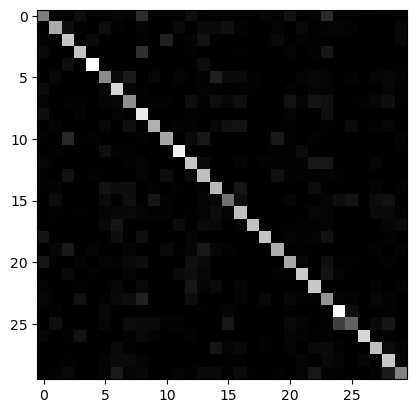

In [56]:
display_cnfm(cnfm=train_cnfm, title="Confusion matrix evaluated on training set.")

Confusion matrix evaluated on validation set.
Each entry indicates percent from total.

[[0.44 0.04 0.04 0.26 0.   0.   0.11 0.11 0.67 0.04 0.   0.   0.15 0.04
  0.   0.   0.07 0.   0.11 0.   0.15 0.   0.11 0.67 0.   0.   0.11 0.07
  0.07 0.  ]
 [0.07 1.63 0.15 0.   0.04 0.19 0.   0.04 0.   0.   0.07 0.07 0.04 0.11
  0.11 0.07 0.04 0.   0.   0.11 0.   0.07 0.04 0.   0.15 0.04 0.   0.
  0.07 0.07]
 [0.   0.04 1.3  0.04 0.19 0.11 0.04 0.   0.04 0.04 0.52 0.   0.22 0.11
  0.04 0.04 0.   0.   0.   0.04 0.   0.04 0.04 0.   0.   0.   0.   0.
  0.04 0.04]
 [0.07 0.   0.   1.44 0.   0.   0.22 0.   0.59 0.04 0.   0.   0.04 0.07
  0.   0.   0.04 0.   0.   0.   0.   0.04 0.   0.52 0.   0.   0.07 0.
  0.   0.11]
 [0.   0.   0.52 0.   2.04 0.   0.   0.   0.   0.   0.07 0.   0.04 0.22
  0.   0.   0.   0.   0.   0.04 0.   0.26 0.04 0.   0.04 0.   0.   0.
  0.   0.07]
 [0.   0.07 0.04 0.04 0.   1.3  0.04 0.11 0.07 0.04 0.04 0.04 0.   0.04
  0.11 0.22 0.11 0.   0.   0.04 0.   0.   0.   0.11 0.07 0.07 0

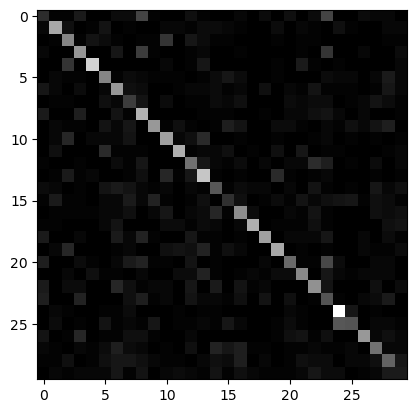

In [57]:
display_cnfm(cnfm=val_cnfm, title="Confusion matrix evaluated on validation set.")

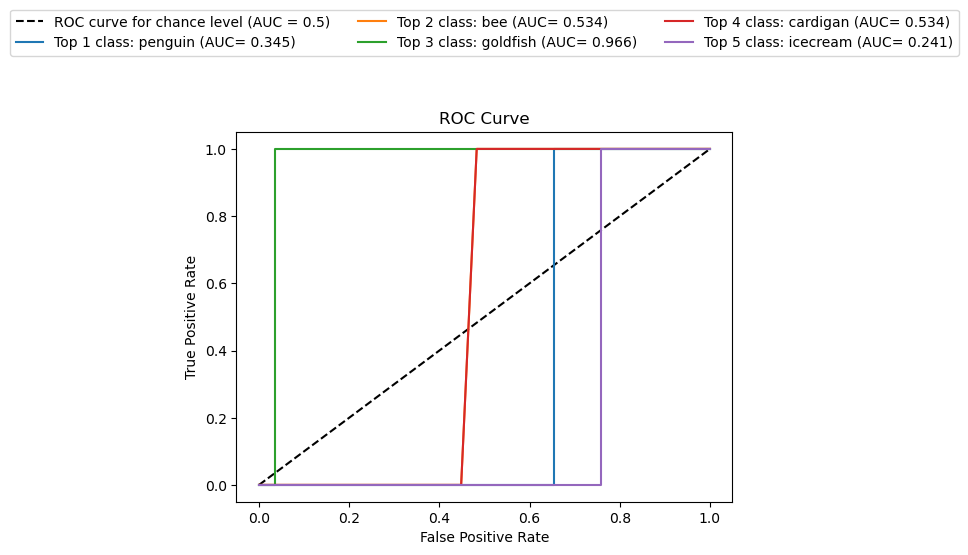

In [132]:
display_roc(cnfm=val_cnfm, nclasses=30)

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


Sanity check for an example of augmented image from training set


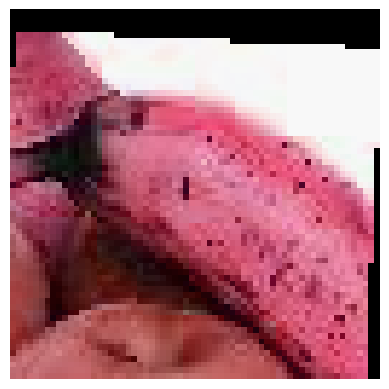

CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)
Epoch 0 		 training loss:  2.517
Epoch 0 		 training topk accuracy:  28.319
Epoch 0 		 new validation accuracy maximum  33.983
Epoch 1 		 training loss:  2.392
Epoch 1 		 training topk accuracy:  31.167
Epoch 1 		 new validation accuracy maximum  35.821
Epoch 2 		 training loss:  2.305
Epoch 2 		 training topk accuracy:  33.552
Epoch 2 		 new validation accuracy maximum  37.059
Epoch 3 		 training loss:  2.243
Epoch 3 		 training topk accuracy:  35.244
Epoch 3 		 new validation accuracy maximum  38.333
Epoch 4 		 training loss:  2.196
Epoch 4 		 training topk accuracy:  36.566
Epoch 4 

Epoch 88 		 training loss:  1.189
Epoch 88 		 training topk accuracy:  64.691
Epoch 89 		 training loss:  1.175
Epoch 89 		 training topk accuracy:  64.238
Epoch 90 		 training loss:  1.174
Epoch 90 		 training topk accuracy:  63.979
Epoch 91 		 training loss:  1.188
Epoch 91 		 training topk accuracy:  64.580
Epoch 92 		 training loss:  1.188
Epoch 92 		 training topk accuracy:  64.081
Epoch 93 		 training loss:  1.187
Epoch 93 		 training topk accuracy:  64.784
Epoch 94 		 training loss:  1.174
Epoch 94 		 training topk accuracy:  64.386
Epoch 95 		 training loss:  1.150
Epoch 95 		 training topk accuracy:  65.440
Epoch 96 		 training loss:  1.157
Epoch 96 		 training topk accuracy:  64.876
Epoch 97 		 training loss:  1.150
Epoch 97 		 training topk accuracy:  65.348
Epoch 98 		 training loss:  1.131
Epoch 98 		 training topk accuracy:  66.235
Epoch 99 		 training loss:  1.174
Epoch 99 		 training topk accuracy:  64.904


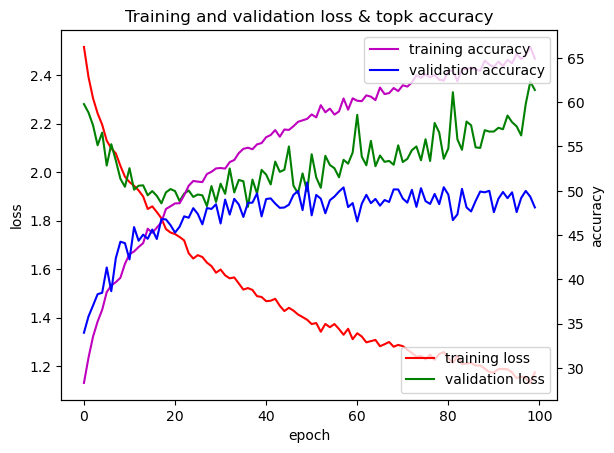

In [16]:
# tensor augmentation strategy to use for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2), 
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.1),
    transforms.RandomAutocontrast(p=0.1)
])

# the same training set, but this time introduce augmentation during training  
train_set = LoadTinyImage30TrainSet(transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

data, label = train_set[450]
print("Sanity check for an example of augmented image from training set")
aug_img = timshow(data)

# fine tune the most accurate CNN model with augmentations
aug_net = CNNClassifier()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")
aug_net.load_state_dict(checkpoint['state_dict']) # load the state of the most accurate cnn

aug_loss_fn = nn.CrossEntropyLoss()
aug_optimizer = optim.SGD(aug_net.parameters(), lr=0.01, momentum=0.9)
print(aug_net)
train_model(100, aug_net, aug_loss_fn, aug_optimizer, ROOT, "augmented_cnnclassifier")

From the above graph on the Training and validation loss & accuracy of the augmented CNN model it can be observed that the validation accuracy increases rapidly in the initial epochs.The model reaches as high as ~51 accuracy in validation which is 12 higher than the CNN model without augmentation (39 validation accuracy) . It can also be observed that the validation loss reduces up to a certain point, after which it starts to increase due to over-fitting even with augmentation technique, albeit at a much slower pace. From the above points it can be concluded that the 5 augmentation (both photometric and geometric) techniques improve the generalisation of the CNN model from Q2.1. This is likely due to the added variability and flexibility the image augmentations provide, which enables the model to make more accurate predictions on unseen images (reduces over-fitting).

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [35]:
class Dropout_CNNClassifier(nn.Module):
    
    def __init__(self, num_classes=30): # TinyImage30 data contains 30 class labels
        super(Dropout_CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=40,kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=40,out_channels=80,kernel_size=3)
        self.fc1 = nn.Linear(15680, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)
        
        # Droput 25 % of neurons
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
dropout_net = Dropout_CNNClassifier()
dropout_loss_fn = nn.CrossEntropyLoss()
dropout_optimizer = optim.SGD(dropout_net.parameters(), lr=0.01, momentum=0.9)
print(dropout_net)   

checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")
dropout_net.load_state_dict(checkpoint['state_dict']) # load the state of the most accurate cnn

# the same training set, but this time exclude augmentation during training  
train_set = LoadTinyImage30TrainSet()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

train_model(100, dropout_net, dropout_loss_fn, dropout_optimizer, ROOT, "dropout_cnnclassifier")

Dropout_CNNClassifier(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=15680, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch 0 		 training loss:  1.623
Epoch 0 		 training topk accuracy:  50.971
Epoch 0 		 new validation accuracy maximum  39.547
Epoch 1 		 training loss:  1.167
Epoch 1 		 training topk accuracy:  64.201
Epoch 2 		 training loss:  0.826
Epoch 2 		 training topk accuracy:  74.029
Epoch 3 		 training loss:  0.582
Epoch 3 		 training topk accuracy:  81.583
Epoch 4 		 training loss:  0.416
Epoch 4 		 training topk accuracy:  86.788
Epoch 5 		 training loss:  0.283
Epoch 5 		 training topk accuracy:  91.189
Epoch 6 		 training loss:  0.233


Epoch 98 		 training loss:  0.000
Epoch 98 		 training topk accuracy:  100.000
Epoch 99 		 training loss:  0.000
Epoch 99 		 training topk accuracy:  100.000


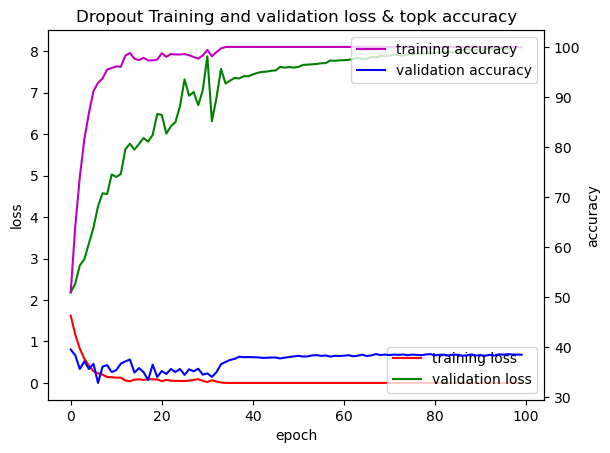

In [41]:
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/dropout_cnnclassifier.pt", 
                       "roc_dcnn.svg",
                      "Dropout Training and validation loss & topk accuracy")

The dropout size was chosen as 0.25 (25 % of total). The idea was to make this value large enough such that it prevents over-fitting, but not too large in order to avoid under fitting (failing to capture the true complexity of an image). Dropout technique did not impact validation accuracy of the fine-tuned CNN model and it started over-fitting right from the initial epochs even with 1/4 of the outputs being dropped out. 

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [42]:
ht_net = CNNClassifier()
ht_loss_fn = nn.CrossEntropyLoss()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")
ht_net.load_state_dict(checkpoint['state_dict']) # load the state of the most accurate cnn

ht_optimizer = optim.SGD(ht_net.parameters(), lr=0.1, momentum=0.9)

train_model(100, ht_net, ht_loss_fn, ht_optimizer, ROOT, "ht_cnnclassifier1")

# reset to original weights before trying next hyper-parameter
ht_net.load_state_dict(checkpoint['state_dict'])
ht_optimizer = optim.SGD(ht_net.parameters(), lr=0.001, momentum=0.9)
train_model(100, ht_net, ht_loss_fn, ht_optimizer, ROOT, "ht_cnnclassifier2")

# reset for final hyper-parameter tuning
ht_net.load_state_dict(checkpoint['state_dict'])
ht_optimizer = optim.SGD(ht_net.parameters(), lr=0.0001, momentum=0.9)
train_model(100, ht_net, ht_loss_fn, ht_optimizer, ROOT, "ht_cnnclassifier3")


Epoch 0 		 training loss:  3.252
Epoch 0 		 training topk accuracy:  8.589
Epoch 0 		 new validation accuracy maximum  7.169
Epoch 1 		 training loss:  3.206
Epoch 1 		 training topk accuracy:  8.155
Epoch 1 		 new validation accuracy maximum  9.669
Epoch 2 		 training loss:  3.190
Epoch 2 		 training topk accuracy:  8.376
Epoch 3 		 training loss:  3.189
Epoch 3 		 training topk accuracy:  8.450
Epoch 4 		 training loss:  3.149
Epoch 4 		 training topk accuracy:  9.292
Epoch 5 		 training loss:  3.169
Epoch 5 		 training topk accuracy:  9.541
Epoch 5 		 new validation accuracy maximum  9.926
Epoch 6 		 training loss:  3.155
Epoch 6 		 training topk accuracy:  8.922
Epoch 7 		 training loss:  3.206
Epoch 7 		 training topk accuracy:  8.303
Epoch 8 		 training loss:  3.262
Epoch 8 		 training topk accuracy:  6.121
Epoch 9 		 training loss:  3.236
Epoch 9 		 training topk accuracy:  7.017
Epoch 10 		 training loss:  3.221
Epoch 10 		 training topk accuracy:  7.184
Epoch 11 		 training lo

Epoch 3 		 new validation accuracy maximum  41.949
Epoch 4 		 training loss:  0.659
Epoch 4 		 training topk accuracy:  80.205
Epoch 5 		 training loss:  0.576
Epoch 5 		 training topk accuracy:  83.358
Epoch 5 		 new validation accuracy maximum  42.096
Epoch 6 		 training loss:  0.501
Epoch 6 		 training topk accuracy:  85.956
Epoch 7 		 training loss:  0.429
Epoch 7 		 training topk accuracy:  88.286
Epoch 8 		 training loss:  0.361
Epoch 8 		 training topk accuracy:  90.597
Epoch 9 		 training loss:  0.299
Epoch 9 		 training topk accuracy:  92.835
Epoch 10 		 training loss:  0.242
Epoch 10 		 training topk accuracy:  94.776
Epoch 11 		 training loss:  0.197
Epoch 11 		 training topk accuracy:  96.228
Epoch 12 		 training loss:  0.159
Epoch 12 		 training topk accuracy:  97.162
Epoch 13 		 training loss:  0.127
Epoch 13 		 training topk accuracy:  98.132
Epoch 14 		 training loss:  0.100
Epoch 14 		 training topk accuracy:  98.706
Epoch 15 		 training loss:  0.081
Epoch 15 		 traini

Epoch 4 		 new validation accuracy maximum  41.728
Epoch 5 		 training loss:  0.982
Epoch 5 		 training topk accuracy:  70.322
Epoch 5 		 new validation accuracy maximum  41.752
Epoch 6 		 training loss:  0.964
Epoch 6 		 training topk accuracy:  70.729
Epoch 6 		 new validation accuracy maximum  41.985
Epoch 7 		 training loss:  0.949
Epoch 7 		 training topk accuracy:  71.311
Epoch 8 		 training loss:  0.934
Epoch 8 		 training topk accuracy:  71.718
Epoch 9 		 training loss:  0.920
Epoch 9 		 training topk accuracy:  72.282
Epoch 10 		 training loss:  0.906
Epoch 10 		 training topk accuracy:  72.457
Epoch 11 		 training loss:  0.893
Epoch 11 		 training topk accuracy:  72.984
Epoch 12 		 training loss:  0.881
Epoch 12 		 training topk accuracy:  73.243
Epoch 13 		 training loss:  0.870
Epoch 13 		 training topk accuracy:  73.678
Epoch 14 		 training loss:  0.858
Epoch 14 		 training topk accuracy:  74.168
Epoch 15 		 training loss:  0.847
Epoch 15 		 training topk accuracy:  74.621

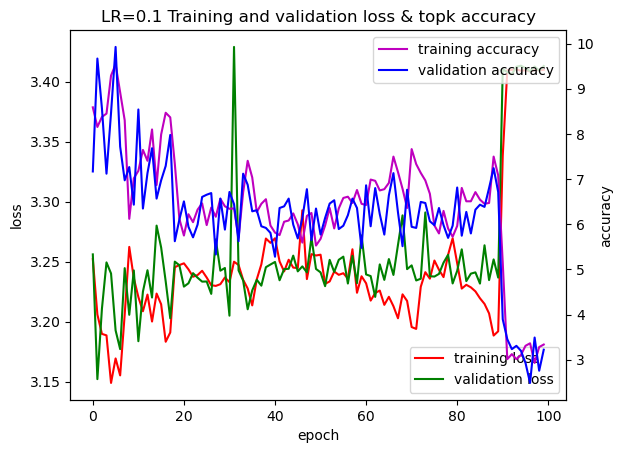

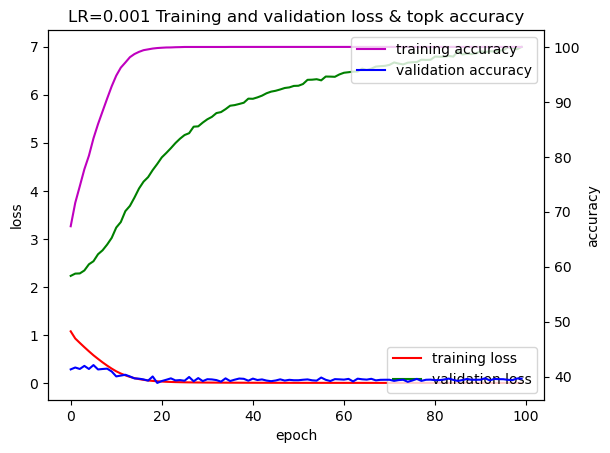

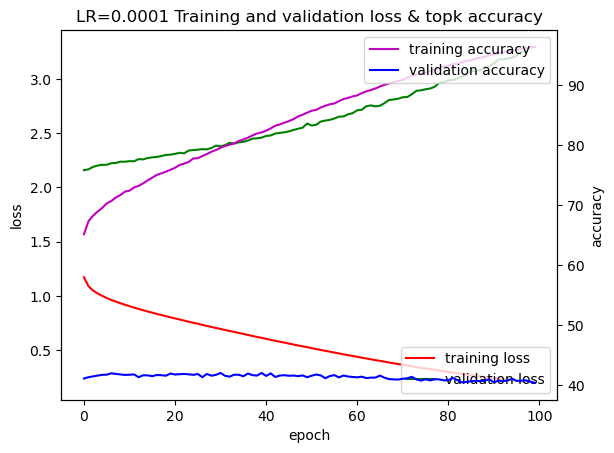

In [43]:
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/ht_cnnclassifier1.pt", 
                       "roc_ftcnn1.svg",
                      "LR=0.1 Training and validation loss & topk accuracy")

plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/ht_cnnclassifier2.pt", 
                       "roc_ftcnn2.svg",
                      "LR=0.001 Training and validation loss & topk accuracy")

plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/ht_cnnclassifier3.pt", 
                       "roc_ftcnn3.svg",
                      "LR=0.0001 Training and validation loss & topk accuracy")

Learning rate of 0.1 is too fast and diverges quickly. Learning rates of 0.001 and 0.0001 achieved similar accuracies, with the only difference that training & validation loss accumulated faster in the model with 0.0001.

### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [199]:
class TestDataSet(Dataset):
    def __init__(self, test_dir):
        self.test_dir = test_dir
        self.transform = transforms.ToTensor()
        all_imgs = os.listdir(test_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.test_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]

test_set = TestDataSet(test_dir="test_set/test_set")
test_loader = DataLoader(test_set, batch_size=1,  num_workers=0)
test_n = len(test_loader)
print("number of test set images: " + str(test_n))

final_net = CNNClassifier()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/augmented_cnnclassifier.pt")
final_net.load_state_dict(checkpoint['state_dict'])

def test(model):
    img_names = [None] * test_n
    predictions = [None] * test_n
    i = 0
    with torch.no_grad():
        for img, name in test_loader:
            img_names[i] = name[0]
            output = model(img)
            # take the max value as the prediction, where its arg (index) 
            # in the output corresponds to the predicted class
            predictions[i] = torch.argmax(output)
            i += 1
    
    return img_names, predictions
        
img_names, predictions = test(final_net)
print('Predictions on test set complete.')

number of test set images: 1500
Predictions on test set complete.


#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [202]:
def write_predictions():
    f = open("sc18s2h.csv", "w")
    f.write("Id,Category\n")
    for i in range(test_n):
        if i != test_n - 1:
            f.write("{},{}\n".format(img_names[i], predictions[i]))
        else:
            f.write("{},{}".format(img_names[i], predictions[i])) # no new line if last entry
    f.close()
    print('sc18s2h.csv file was generated successfully. Ready to be submitted :)')
    
write_predictions()

sc18s2h.csv file was generated successfully. Ready to be submitted :)



### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [13]:
# tensor augmentation strategy to use for training
train_transform = transforms.Compose([
    transforms.Resize(256), # Alex net requires image to be of size at least 224
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalization required from Alexnet
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2), 
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)), 
    transforms.RandomHorizontalFlip(p=0.5), 
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_set = torchvision.datasets.CIFAR10(root="C:/Users/Laptop/Desktop/cw/cifar10/", 
                                               train = True, 
                                               transform = train_transform, 
                                               download = True)

validation_set = train_set = torchvision.datasets.CIFAR10(root="C:/Users/Laptop/Desktop/cw/cifar10/", 
                                               train = True, 
                                               transform = val_transform, 
                                               download = False)

# handle partitioning of train & validation sets 
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train)) # 20 % used for validation

np.random.seed(0) # with shuffle seed 0 for reproducability
np.random.shuffle(indices)

train_idx, validation_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx) 

# the training set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

# validation set
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE,  
                          num_workers=NUM_WORKERS, sampler=validation_sampler)


Files already downloaded and verified


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [21]:
# load alex net
alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\Laptop/.cache\torch\hub\pytorch_vision_v0.10.0


In [17]:
# change the output from 1000 classes to 10
print(alex_net.classifier[6]) # the output layer before the change
alex_net.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
print(alex_net.classifier[6]) # the output layer after the change

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=10, bias=True)


#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [18]:
alex_parameters = filter(lambda p: p.requires_grad, alex_net.parameters())
n_params = sum([np.prod(p.size()) for p in alex_parameters])
print(f"Alex net has a total of {n_params} trainable parameters")

print(alex_net)

Alex net has a total of 57044810 trainable parameters
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Li

In [19]:
alex_loss_fn = nn.CrossEntropyLoss()
alex_optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)
train_model(25, alex_net, alex_loss_fn, alex_optimizer, ROOT, "alex_classifier")

Epoch 0 		 training loss:  0.832
Epoch 0 		 training topk accuracy:  70.545
Epoch 0 		 new validation accuracy maximum  81.819
Epoch 1 		 training loss:  0.449
Epoch 1 		 training topk accuracy:  84.360
Epoch 2 		 training loss:  0.330
Epoch 2 		 training topk accuracy:  88.478
Epoch 2 		 new validation accuracy maximum  85.204
Epoch 3 		 training loss:  0.254
Epoch 3 		 training topk accuracy:  91.070
Epoch 3 		 new validation accuracy maximum  86.442
Epoch 4 		 training loss:  0.189
Epoch 4 		 training topk accuracy:  93.368
Epoch 4 		 new validation accuracy maximum  87.200
Epoch 5 		 training loss:  0.140
Epoch 5 		 training topk accuracy:  95.127
Epoch 5 		 new validation accuracy maximum  89.067
Epoch 6 		 training loss:  0.099
Epoch 6 		 training topk accuracy:  96.578
Epoch 6 		 new validation accuracy maximum  89.167
Epoch 7 		 training loss:  0.066
Epoch 7 		 training topk accuracy:  97.843
Epoch 7 		 new validation accuracy maximum  89.397
Epoch 8 		 training loss:  0.041
Ep

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [23]:
def print_trainable_net_parameters(model):
    for name, para in model.named_parameters():
        if para.requires_grad: # print only trainable parameters
            print("-"*20)
            print(f"name: {name}")
            print(f"values size: {para.shape}")

def freeze_convolutions(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'features' in name: # freeze the convolution blocks
            param.requires_grad = False
            
    non_frozen_parameters = [p for p in model.parameters() if p.requires_grad]
    return non_frozen_parameters

alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex_net.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
frozen_alex_optimizer = optim.SGD(freeze_convolutions(alex_net), lr=0.001)
print("Trainable parameters (after freeze):\n")
print_trainable_net_parameters(alex_net)

Using cache found in C:\Users\Laptop/.cache\torch\hub\pytorch_vision_v0.10.0


Trainable parameters (after freeze):

--------------------
name: classifier.1.weight
values size: torch.Size([4096, 9216])
--------------------
name: classifier.1.bias
values size: torch.Size([4096])
--------------------
name: classifier.4.weight
values size: torch.Size([4096, 4096])
--------------------
name: classifier.4.bias
values size: torch.Size([4096])
--------------------
name: classifier.6.weight
values size: torch.Size([10, 4096])
--------------------
name: classifier.6.bias
values size: torch.Size([10])


In [24]:
train_model(25, alex_net, alex_loss_fn, frozen_alex_optimizer, ROOT, "alex_frozen_classifier")

Epoch 0 		 training loss:  1.411
Epoch 0 		 training topk accuracy:  51.398
Epoch 0 		 new validation accuracy maximum  62.829
Epoch 1 		 training loss:  1.009
Epoch 1 		 training topk accuracy:  65.248
Epoch 1 		 new validation accuracy maximum  66.593
Epoch 2 		 training loss:  0.903
Epoch 2 		 training topk accuracy:  68.815
Epoch 2 		 new validation accuracy maximum  69.579
Epoch 3 		 training loss:  0.843
Epoch 3 		 training topk accuracy:  70.698
Epoch 3 		 new validation accuracy maximum  71.346
Epoch 4 		 training loss:  0.801
Epoch 4 		 training topk accuracy:  72.142
Epoch 4 		 new validation accuracy maximum  72.624
Epoch 5 		 training loss:  0.768
Epoch 5 		 training topk accuracy:  73.278
Epoch 5 		 new validation accuracy maximum  72.784
Epoch 6 		 training loss:  0.741
Epoch 6 		 training topk accuracy:  74.255
Epoch 6 		 new validation accuracy maximum  73.642
Epoch 7 		 training loss:  0.718
Epoch 7 		 training topk accuracy:  75.073
Epoch 7 		 new validation accuracy 

#### 4.3 Compare above configurations and comment on comparative performance

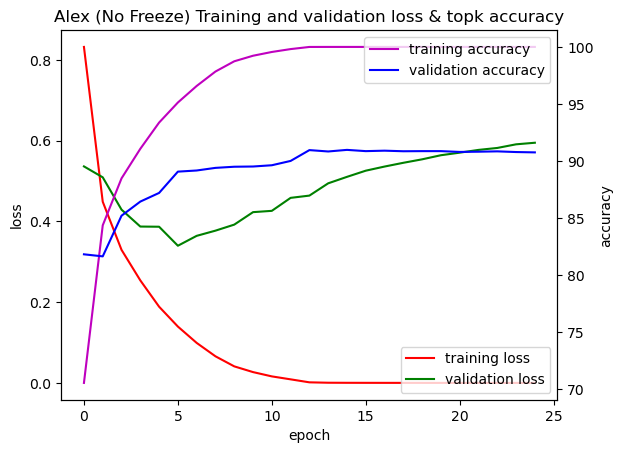

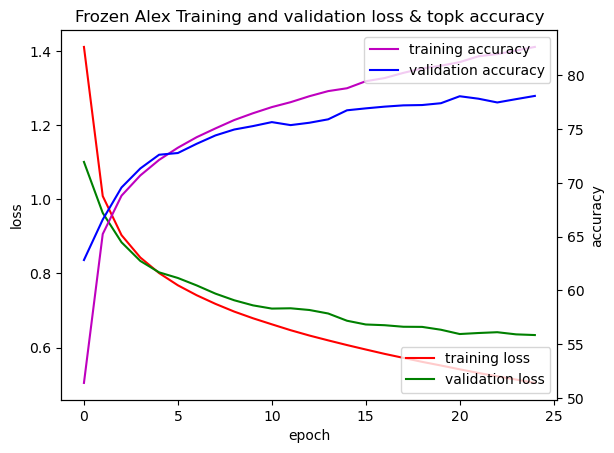

In [25]:
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/alex_classifier.pt", 
                       "roc_alex.svg",
                      "Alex (No Freeze) Training and validation loss & topk accuracy")
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/alex_frozen_classifier.pt", 
                       "roc_frozen_alex.svg",
                      "Frozen Alex Training and validation loss & topk accuracy")

From the above graphs it can be observed that the AlexNet model with no frozen layers successfully converges on the CIFAR10 training set, while also achieving very high accuracy in validation (90%). 

On the other hand, The AlexNet model with frozen convolution blocks also improves it's accuracy on training and validation sets  but at a much slower rate. Without optimising the convolution layers during training, the model very slowly reduces loss in contrast to fine-tuning all parameters. The topk1 accuracy after the same number of training epochs (25) is 12 lower, thus comparatively worse than fine-tuning all parameters. 

This indicates that the weights & gradients of the convolution layers are very important to be fine-tuned during training even if pre-trained weights are available. That is because the pre-trained weights in the convolutions have not been trained to fit the CIFAR10 dataset exactly, thus adjusting those at run-time improves the speed at which the model learns to classify these images.

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [26]:
# tensor augmentation strategy to use for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2), 
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.1),
    transforms.RandomAutocontrast(p=0.1)
])

BATCH_SIZE = 32

# load the same TinyImage30 dataset
train_set = LoadTinyImage30TrainSet()
validation_set = LoadTinyImage30TrainSet()

# handle partitioning of train & validation sets 
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train)) # 20 % used for validation

np.random.seed(0) # with shuffle seed 0 for reproducability
np.random.shuffle(indices)

train_idx, validation_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx) 

# the training set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, sampler=train_sampler)

# validation set
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE,  
                          num_workers=NUM_WORKERS, sampler=validation_sampler)

# modified training for models, where we train until the model converges in the training set
def train_model_convergence(nepochs: int, model, loss_fn, optimizer, root_path: str, file_name: str):
    if torch.cuda.is_available(): # load the network in GPU if available
        model = model.cuda()
        
    statsrec = np.zeros((4,nepochs)) # record stats for testing & validation

    start = time.time() # start timing execution
    for epoch in range(nepochs):  # loop over the dataset multiple times
        train_loss = 0.0   # accumulated loss
        train_acc = 0.0    # accumulated accuracy
        n = 0 # batch counter for averaging accumulated values

        for data, labels in train_loader:
            if torch.cuda.is_available(): # load the data in GPU if available
                data, labels = data.cuda(), labels.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # accumulate loss
            train_loss += loss.item()
            # accumulate topk accuracy
            train_acc += torch.tensor(topk_accuracy(outputs, labels), device = 'cpu').item()
            n += 1
     
        # collect together statistics for this epoch (take the mean across all batches)
        train_loss = train_loss/n
        train_acc = train_acc/n

        print(f"Epoch {epoch} \t\t training loss: {train_loss: .3f}")
        print(f"Epoch {epoch} \t\t training topk accuracy: {train_acc: .3f}")

        # accumulate loss & accuracy for validation
        validation_loss = 0.0
        validation_acc = 0.0
        n = 0
        # evaluate, e.g. do not compute gradients for validation
        model.eval()
        for data, labels in validation_loader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            output = model(data)
            loss = loss_fn(output,labels)
            validation_loss += loss.item()
            validation_acc += torch.tensor(topk_accuracy(output, labels), device = 'cpu').item()
            n += 1

        # average the accumulated values
        validation_loss = validation_loss / n
        validation_acc = validation_acc / n
        # record the stats for this epoch
        statsrec[:,epoch] = (train_loss, train_acc, validation_loss, validation_acc)
        
        if abs(train_loss - 0) <= 0.001 or abs(train_acc - 100) <= 0.00001:
            # save network parameters, losses and accuracy to 
            # specified path when the model converges to train set
            optimal_path = root_path + "results/converged_" + file_name + ".pt"
            torch.save({"state_dict": model.state_dict(), "stats": statsrec[:][:epoch+1], "time": end-start}, optimal_path)
            end = time.time() # stop timing execution
            break
        
        end = time.time()
        # the model might fail to converge after nepochs, therefore save at the end 
        results_path = root_path + "results/" + file_name + ".pt"
        torch.save({"state_dict": model.state_dict(), "stats": statsrec, "time": end-start}, results_path)

In [27]:
alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# fix the output class to be 30 instead of the original 1000
alex_net.classifier[6] = nn.Linear(in_features=4096, out_features=30, bias=True) 
alex_loss_fn = nn.CrossEntropyLoss()
alex_optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)
train_model_convergence(20, alex_net, alex_loss_fn, alex_optimizer, ROOT, "alex_tiny_image_classifier")

Using cache found in C:\Users\Laptop/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 0 		 training loss:  1.972
Epoch 0 		 training topk accuracy:  42.872
Epoch 1 		 training loss:  1.253
Epoch 1 		 training topk accuracy:  62.491
Epoch 2 		 training loss:  0.906
Epoch 2 		 training topk accuracy:  71.616
Epoch 3 		 training loss:  0.613
Epoch 3 		 training topk accuracy:  81.000
Epoch 4 		 training loss:  0.367
Epoch 4 		 training topk accuracy:  88.563
Epoch 5 		 training loss:  0.205
Epoch 5 		 training topk accuracy:  93.815
Epoch 6 		 training loss:  0.098
Epoch 6 		 training topk accuracy:  97.365
Epoch 7 		 training loss:  0.065
Epoch 7 		 training topk accuracy:  98.391
Epoch 8 		 training loss:  0.030
Epoch 8 		 training topk accuracy:  99.399
Epoch 9 		 training loss:  0.012
Epoch 9 		 training topk accuracy:  99.852
Epoch 10 		 training loss:  0.002
Epoch 10 		 training topk accuracy:  100.000


In [70]:
# train my model on the same dataset (no augmentations) 
# but this time record how long it executes and
# train until convergence on train set (instead of validated accuracy)
my_net = CNNClassifier()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/optimal_cnnclassifier.pt")
my_net.load_state_dict(checkpoint['state_dict'])

my_loss_fn = nn.CrossEntropyLoss()
my_optimizer = optim.SGD(my_net.parameters(), lr=0.01, momentum=0.9)
train_model_convergence(100, my_net, my_loss_fn, my_optimizer, ROOT, "mymodel")

Epoch 0 		 training loss:  1.419
Epoch 0 		 training topk accuracy:  56.897
Epoch 1 		 training loss:  1.116
Epoch 1 		 training topk accuracy:  65.884
Epoch 2 		 training loss:  0.800
Epoch 2 		 training topk accuracy:  74.991
Epoch 3 		 training loss:  0.546
Epoch 3 		 training topk accuracy:  82.933
Epoch 4 		 training loss:  0.370
Epoch 4 		 training topk accuracy:  88.425
Epoch 5 		 training loss:  0.300
Epoch 5 		 training topk accuracy:  90.514
Epoch 6 		 training loss:  0.240
Epoch 6 		 training topk accuracy:  92.243
Epoch 7 		 training loss:  0.183
Epoch 7 		 training topk accuracy:  94.222
Epoch 8 		 training loss:  0.157
Epoch 8 		 training topk accuracy:  95.146
Epoch 9 		 training loss:  0.165
Epoch 9 		 training topk accuracy:  94.887
Epoch 10 		 training loss:  0.133
Epoch 10 		 training topk accuracy:  95.969
Epoch 11 		 training loss:  0.081
Epoch 11 		 training topk accuracy:  97.476
Epoch 12 		 training loss:  0.062
Epoch 12 		 training topk accuracy:  98.012
Epoch 

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


Alex net performance on Tiny Image dataset: 


Alex net total execution time: 		 137.522 seconds


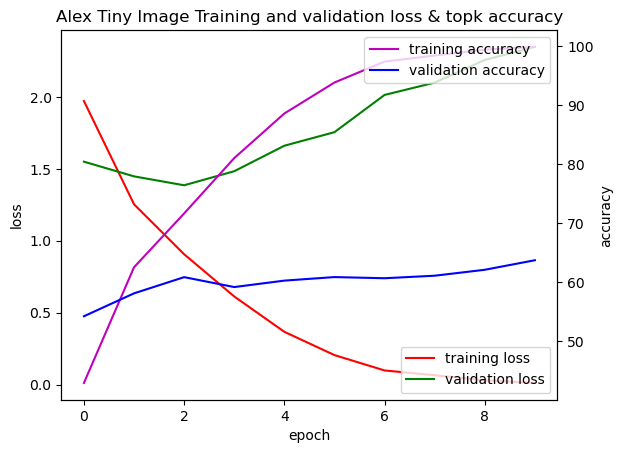

Confusion matrix for Alex on validation set
Each entry indicates percent from total.

[[1.48 0.04 0.   0.11 0.   0.   0.   0.26 0.3  0.   0.   0.   0.   0.
  0.   0.07 0.   0.04 0.15 0.   0.19 0.   0.11 0.22 0.   0.   0.11 0.07
  0.11 0.  ]
 [0.   2.04 0.   0.   0.   0.11 0.   0.   0.   0.04 0.04 0.04 0.04 0.15
  0.04 0.   0.04 0.04 0.   0.11 0.   0.07 0.07 0.   0.07 0.19 0.   0.
  0.04 0.07]
 [0.   0.07 1.48 0.   0.15 0.   0.04 0.   0.   0.   0.52 0.04 0.04 0.07
  0.   0.11 0.   0.   0.   0.11 0.   0.07 0.   0.04 0.   0.07 0.07 0.
  0.   0.  ]
 [0.11 0.   0.   2.26 0.   0.   0.04 0.04 0.19 0.   0.   0.   0.11 0.
  0.   0.   0.04 0.   0.   0.   0.15 0.07 0.07 0.11 0.   0.   0.04 0.
  0.   0.04]
 [0.   0.04 0.11 0.   2.81 0.04 0.   0.   0.   0.   0.04 0.   0.   0.11
  0.   0.04 0.   0.   0.   0.04 0.   0.04 0.   0.   0.   0.   0.   0.04
  0.   0.04]
 [0.04 0.11 0.   0.   0.   1.81 0.   0.   0.   0.04 0.   0.07 0.04 0.
  0.07 0.07 0.11 0.07 0.   0.   0.   0.   0.   0.04 0.07 0.11 0.07 0.

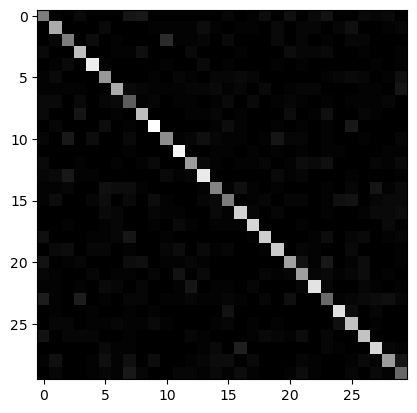

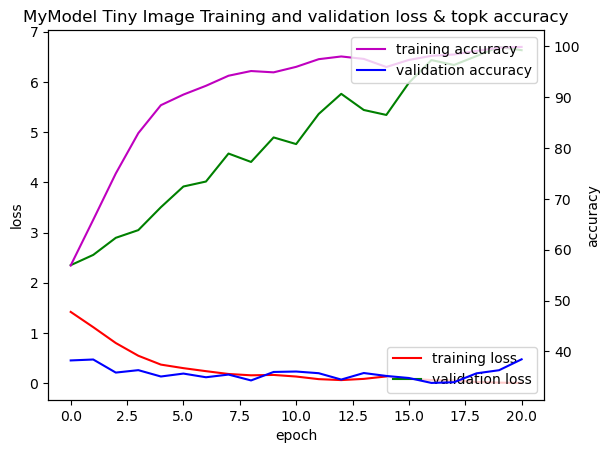

Confusion matrix for MyModel on validation set
Each entry indicates percent from total.

[[1.48 0.04 0.   0.11 0.   0.   0.   0.26 0.3  0.   0.   0.   0.   0.
  0.   0.07 0.   0.04 0.15 0.   0.19 0.   0.11 0.22 0.   0.   0.11 0.07
  0.11 0.  ]
 [0.   2.04 0.   0.   0.   0.11 0.   0.   0.   0.04 0.04 0.04 0.04 0.15
  0.04 0.   0.04 0.04 0.   0.11 0.   0.07 0.07 0.   0.07 0.19 0.   0.
  0.04 0.07]
 [0.   0.07 1.48 0.   0.15 0.   0.04 0.   0.   0.   0.52 0.04 0.04 0.07
  0.   0.11 0.   0.   0.   0.11 0.   0.07 0.   0.04 0.   0.07 0.07 0.
  0.   0.  ]
 [0.11 0.   0.   2.26 0.   0.   0.04 0.04 0.19 0.   0.   0.   0.11 0.
  0.   0.   0.04 0.   0.   0.   0.15 0.07 0.07 0.11 0.   0.   0.04 0.
  0.   0.04]
 [0.   0.04 0.11 0.   2.81 0.04 0.   0.   0.   0.   0.04 0.   0.   0.11
  0.   0.04 0.   0.   0.   0.04 0.   0.04 0.   0.   0.   0.   0.   0.04
  0.   0.04]
 [0.04 0.11 0.   0.   0.   1.81 0.   0.   0.   0.04 0.   0.07 0.04 0.
  0.07 0.07 0.11 0.07 0.   0.   0.   0.   0.   0.04 0.07 0.11 0.07

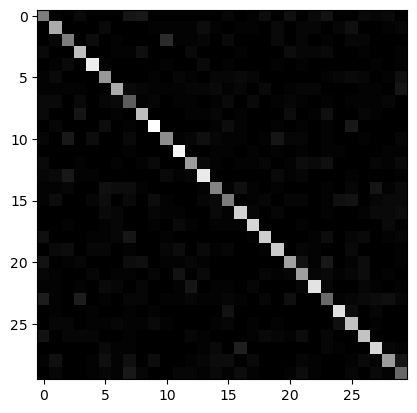

In [30]:
data = torch.load("C:/Users/Laptop/Desktop/cw/results/converged_alex_tiny_image_classifier.pt")
print("Alex net performance on Tiny Image dataset: \n\n")
exec_time = data["time"]
print(f"Alex net total execution time: \t\t{exec_time: .3f} seconds")
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/converged_alex_tiny_image_classifier.pt", 
                       "roc_alex_tiny_image.svg",
                      "Alex Tiny Image Training and validation loss & topk accuracy", 10)

alex_net.cpu()
alex_cnfm = generate_cnfm(alex_net, 
                          validation_loader, 
                          30, 
                          "C:/Users/Laptop/Desktop/cw/results/converged_alex_tiny_image_classifier.pt")
display_cnfm(cnfm=alex_cnfm, title="Confusion matrix for Alex on validation set", gray_map=True)

print("\nMyModel performance on Tiny Image dataset: \n\n")
data = torch.load("C:/Users/Laptop/Desktop/cw/results/converged_mymodel.pt")
exec_time = data["time"]
print(f"MyModel execution time: \t\t{exec_time: .3f} seconds")
plot_model_train_stats("C:/Users/Laptop/Desktop/cw/results/converged_mymodel.pt", 
                       "roc_converged_mymodel.svg", 
                       "MyModel Tiny Image Training and validation loss & topk accuracy", 
                       21)

my_net = CNNClassifier()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/mymodel.pt")
my_net.load_state_dict(checkpoint['state_dict'])
my_net.cpu()
my_cnfm = generate_cnfm(my_net, 
                        validation_loader, 
                        30, 
                        "C:/Users/Laptop/Desktop/cw/results/converged_mymodel.pt")
display_cnfm(cnfm=alex_cnfm, title="Confusion matrix for MyModel on validation set", gray_map=True)



### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [32]:
# load my model
final_net = CNNClassifier()
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/augmented_cnnclassifier.pt")
final_net.load_state_dict(checkpoint['state_dict'])
final_net.eval()

# load AlexNet model
alex_retrained_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
# fix the output class to be 30 instead of the original 1000
alex_retrained_net.classifier[6] = nn.Linear(in_features=4096, out_features=30, bias=True) 
checkpoint = torch.load("C:/Users/Laptop/Desktop/cw/results/converged_alex_tiny_image_classifier.pt")
alex_retrained_net.load_state_dict(checkpoint['state_dict'])
alex_retrained_net.eval()

Using cache found in C:\Users\Laptop/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
# Your code here!
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# utility function to load a tensor image from specified path
def load_timage(path):
    img = Image.open(path).convert("RGB")
    to_tensor = transforms.ToTensor()
    # convert to Pytorch tensor
    tensor = to_tensor(img)
    # add another dimension at the front
    tensor = tensor.unsqueeze(0)
    return tensor

# gets the path to 4 correctly/incorrectly classified images by our model
# indicated by the boolean flag 'class_accurate' set to True by default, e.g.
# obtains correctly classified images. Actual_classes is expected array of
# length 4, which should contain 4 distinct string labels from which to select
# 1 correctly/incorrectly classified image. NOTE: error will occurr if no 
# appropriate image was found for any of specified classes.
def get_4_imgs(model, actual_classes, class_accurate=True): 
    path_to_train = "C:/Users/Laptop/Desktop/cw/train_set/train_set/"
    path_to_imgs = ['']*4 # the list of chosen image paths to return
    predicted_classes = ['']*4 # the list of prediction labels when classifying the 4 images
    
    for i in range(len(actual_classes)):
        the_class = actual_classes[i]
        class_path = path_to_train + the_class + '/'
        all_folder_imgs = os.listdir(class_path)
        for img in all_folder_imgs:  
            with torch.no_grad():
                img_path = class_path + img
                output = model(load_timage(img_path))
                prediction = torch.argmax(output).item()
                prediction_label = CLASS_TXT_LABELS[prediction]
                
                # only save path if the image classification was accurate/inaccurate depending on func arg
                if ( prediction_label == the_class) is class_accurate:
                    path_to_imgs[i] = img_path
                    predicted_classes[i] = prediction_label
                    break # move to the next class of interest
    return path_to_imgs, actual_classes, predicted_classes

# Given a model, displays the image being classified next to
# the grad-CAM image produced for the respective target 
# convolutional layers
def visualise_gradcam(model, img, target_layers):
    with GradCAM(model=model, target_layers=target_layers) as cam:
        # Preprocess image and feed it to the model
        input_tensor = load_timage(img)
        grayscale_cam = cam(input_tensor=input_tensor)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        rgb_img = Image.open(img).convert("RGB")
        # grad-CAM operates on np array pixel values of range [0-255] instead of [0-1]
        np_img = np.asarray(rgb_img) / 255.0 # thus convert
        visualization = show_cam_on_image(np_img, grayscale_cam, use_rgb=True)
        
        # plot the actual image and the grad cam image side by side to compare
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(np_img)
        plt.axis('off')
        plt.tight_layout()
        f.add_subplot(1,2, 2)
        plt.imshow(visualization)
        plt.axis('off')
        plt.tight_layout()
        plt.show(block=True)
        
        return Image.fromarray(visualization, 'RGB')

Visualising 4 correctly classified images from our model: 

Image name: n01443537_191.JPEG
Actual class and prediction: goldfish 



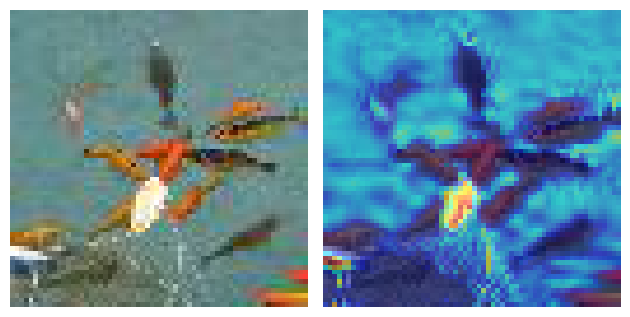

Image name: n02226429_146.JPEG
Actual class and prediction: grasshopper 



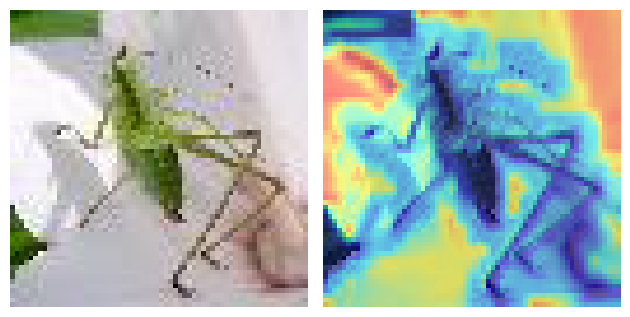

Image name: n02206856_1.JPEG
Actual class and prediction: bee 



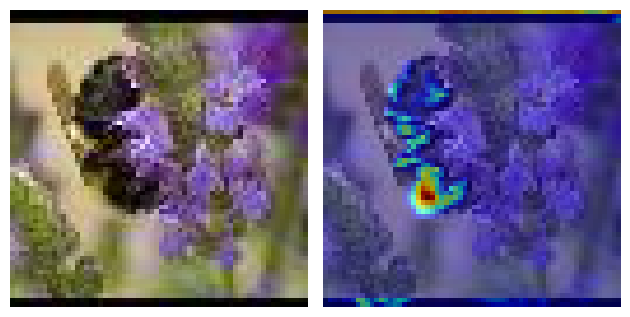

Image name: n07873807_485.JPEG
Actual class and prediction: pizza 



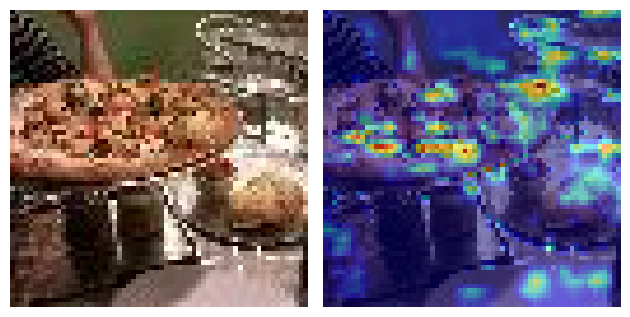

In [34]:
# for my model, plot the grad cam of 4 correctly classified images 
model = final_net
accurate = True

# the 4 chosen classes for this case
actual_classes = ['goldfish', 'grasshopper', 'bee', 'pizza']
[correct_imgs, actual_class_labels, predicted_class_labels] = get_4_imgs(model=model, 
                                                                         actual_classes=actual_classes,
                                                                         class_accurate=accurate 
                                                                         )
print(f'Visualising 4 correctly classified images from our model: \n')

for i in range(4):
    img_name = correct_imgs[i].split("/")[-1]
    print(f'Image name: {img_name}') # only image name extracted from full path
    print(f'Actual class and prediction: {actual_class_labels[i]} \n')
    # produce grad-CAM based on all convolutional layers in the model
    grad_cam_img = visualise_gradcam(model, correct_imgs[i], [model.conv1, model.conv2])
    # save the produced grad cam image to success dir
    grad_cam_img.save("C:/Users/Laptop/Desktop/cw/success/" + img_name + "_gradcam.JPEG")

Visualising 4 incorrectly classified images by AlexNet trained on TinyImage dataset: 

Image name: n01443537_0.JPEG
Actual class is goldfish 		 prediction was espresso


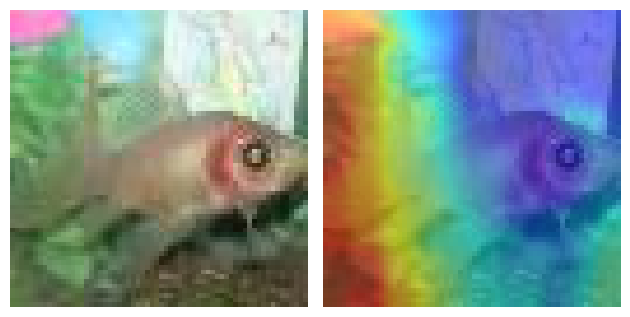

Image name: n02226429_0.JPEG
Actual class is grasshopper 		 prediction was goldfish


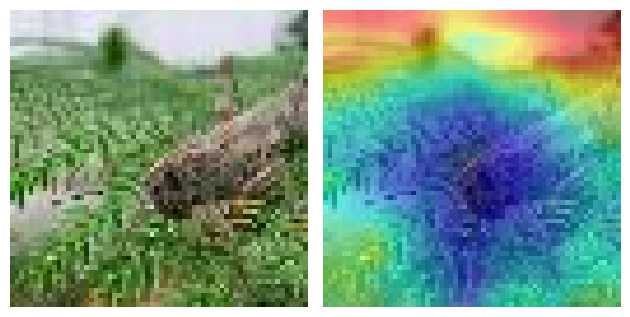

Image name: n02129165_0.JPEG
Actual class is lion 		 prediction was koala


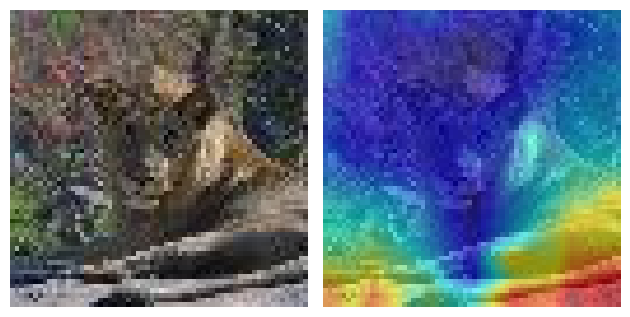

Image name: n02486410_116.JPEG
Actual class is baboon 		 prediction was bison


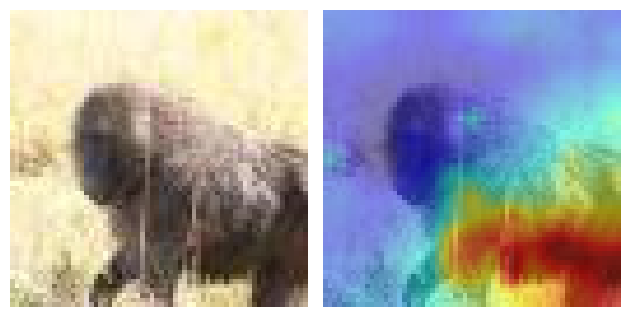

In [35]:
# for my AlexNet, plot the grad cam of 4 incorrectly classified images
model = alex_retrained_net
accurate = False

# the 4 chosen classes for this case
actual_classes = ['goldfish', 'grasshopper', 'lion', 'baboon']
[correct_imgs, actual_class_labels, predicted_class_labels] = get_4_imgs(model=model, 
                                                                         actual_classes=actual_classes,
                                                                         class_accurate=accurate 
                                                                         )
print(f'Visualising 4 incorrectly classified images by AlexNet trained on TinyImage dataset: \n')
    
for i in range(4):
    img_name = correct_imgs[i].split("/")[-1]
    print(f'Image name: {correct_imgs[i].split("/")[-1]}') # only image name extracted from full path
    print(f'Actual class is {actual_class_labels[i]} \t\t prediction was {predicted_class_labels[i]}')
    # produce grad-CAM based on all convolutional layers in the model
    grad_cam_img = visualise_gradcam(model, correct_imgs[i], model.features)
    # save the produced grad_CAM image to failure dir
    grad_cam_img.save("C:/Users/Laptop/Desktop/cw/failure/" + img_name + "_gradcam.JPEG")

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

By displaying the original image and the corresponding grad-CAM heatmap output (highly important features encoded by yellow-red) we observe:

The outline, shape, texture and color of the predicted objects appear to be of highest importance for the convolutional layers when making a decision. These patterns & outlines were not always corresponding to the correct target class label, however. Even still, the patterns the AlexNet found to be prevalent in the incorrectly labelled images do not appear to be random and can be explained as follows:

In the image of a goldfish, which was labelled as espresso we can see higher weights assigned to the top left corner, which resembles an entity containing some liquid (although not the color one would expect an espresso to be), whereas the fish in the middle was probably ignored because it's color hue is not gold/gold-orange enough to be deemed as goldfish with sufficient probability.

Conversely, in the image of a grasshoper, which AlexNet wrongly labelled as goldfish, the pattern that was highlighted was the bright sky & sun. Put together these results indicate that the convolutions of AlexNet find brightness & color to be a strong indicator when classifying an image as a goldfish, rather than finding patterns in its body shape outline. 

Whereas in the case of the baboon that was incorrectly classified as bison, the mistake is assumed to have occurred due to the similarity of both animal's rears and back legs posture. The model was not able to distinguish the differences between the two animals, which are primarily found at their front (head, arms and up-standing posture). In the example of the lion mistaken for a koala, the mistake does appear to be somewhat random. One explanation could be that with the amount of pixels available, the bottom (high heat area) of the image resembled the typical color of a koala, that is perhaps in a laying position on the ground.

As for the correctly classified images by my model: 

* A single goldfish was distinguished when correctly classifying the image. Although, the overall outline of its body was of high value for the prediction, the primary reason for the correct classification seems to be the color & brightness of that one fish (consistent with failed classification observations).
* The bee was primarily identified by the shape of its head and yellow/black spots that appear all along the body.  
* Interestingly in the grasshopper image, the model classified correctly based on the area outside of its body outline. In other words, if you remove the hot areas in that mapping, you will be left with only the grasshopper.
* Another interesting observation is that when correctly classifying the pizza image, the model's convolutions found the toppings to be the most indicative pattern.

In order to improve the results further, the following steps can be undertaken:


* increase the number of nodes in each convolutional layer - this will allow the model to recognise more subtle patterns in images, which should reduce errors when distinguishing objects that are similar to each other bar a few minor differences. It is assumed that this should resolve confusion between a baboon and bison for intance. 
* add more convolutional layers - this will allow the model to combine patters from previous layers into deeper & larger observations which should improve its capabilities to recognise complex features. This can resolve the missclassification of a goldfish with espresso for instance, since the window of observation is now larger (easier to focus on the features of the large fish)
* introduce more photometric augmentations, i.e. alter the color, brightness of an image etc - this can improve the performance of the model, if the primary difference between objects is not their color but their body shape etc (grasshoper mistaken for a goldfish).
* if available, train the models on larger labelled datasets which may introduce higher variance (less bias), which could lead to better generalisation (assuming validation is performed).
* use k-fold cross validation which will slow down the training process (k-fold) but ultimately help the models generalise better. This still reduces overfitting but ensures each data point in the training data is used at least once both for training and validation. 

**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
